# Basic usage of modified transformers library (modification have been done only for BERT)

## Setup (Same as "Setup" in README) (Please run only the first once)

We recommend preparing a new virtual environment (python>=3.6) before executing these commands.
Install necessary packages:
> $ cd configs

> $ pip install pip-tools

> $ pip-compile requirements.in

> $ pip-sync

Install PyTorch using the command in 
https://pytorch.org/

e.g.,
>$ pip install torch torchvision torchaudio

## Usage

In [2]:
import torch
from transformers import BertModel, BertTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# Load pretrained model/tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased").to(device)
model.eval()

# Preprocess an input.
text = "Here is some text to encode."
pt_batch = tokenizer(text, return_tensors="pt").to(device)
print(pt_batch)
tokenized_text = tokenizer.convert_ids_to_tokens(pt_batch["input_ids"][0])
print(tokenized_text)

{'input_ids': tensor([[  101,  2182,  2003,  2070,  3793,  2000,  4372, 16044,  1012,   102]],
       device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}
['[CLS]', 'here', 'is', 'some', 'text', 'to', 'en', '##code', '.', '[SEP]']


In [5]:
# If you want to extract vector norms or mixing ratios, please set the argument "output_norms" to True.
with torch.no_grad():
    last_hidden_state, pooler_output, hidden_states, attentions, norms = model(**pt_batch, output_hidden_states=True, output_attentions=True, output_norms=True)

In [6]:
# Returned variable "norms" is a tuple which has 12 elements (equal to the number of layers).
print(type(norms))
print(len(norms))

<class 'tuple'>
12


In [8]:
# Each element is a tuple which consists of 7 elements: 
# 0: head-level Attn-N from Kobayashi et al., 2020
# 1: layer-level Attn-N from Kobayashi et al., 2020
# 2: AttnRes-N
# 3: AttnResLn-N
# 4: Mixing ratios for Attn-N
# 5: Mixing ratios for AttnRes-N
# 6: Mixing ratios for AttnResLn-N

layer = 5
print(type(norms[layer-1]))
print(len(norms[layer-1]))

head_attn_n, attn_n, attnres_n, attnresln_n, attn_n_ratio, attnres_n_ratio, attnresln_n_ratio = norms[layer-1]

<class 'tuple'>
7


In [10]:
# shape of head_attn_n is (batch, num_heads, seq_length)
print('shape of "head_attn_n":', head_attn_n.size())

shape of "head_attn_n": torch.Size([1, 12, 10, 10])


In [15]:
# shape of attn_n is (batch, seq_length, seq_length)
print('shape of "attn_n":', attn_n.size())

shape of "attn_n": torch.Size([1, 10, 10])


In [16]:
# shape of attnres_n is (batch, seq_length, seq_length)
print('shape of "attnres_n":', attnres_n.size())

shape of "attnres_n": torch.Size([1, 10, 10])


In [17]:
# shape of attnres_ln is (batch, seq_length, seq_length)
print('shape of "attnresln_n":', attnresln_n.size())

shape of "attnresln_n": torch.Size([1, 10, 10])


In [18]:
# shape of mixing ratios is (batch, seq_length)
print('shape of "attn_n_ratio":', attn_n_ratio.size())
print('shape of "attnres_n_ratio":', attnres_n_ratio.size())
print('shape of "attnresln_n_ratio":', attnresln_n_ratio.size())

shape of "attn_n_ratio": torch.Size([1, 10])
shape of "attnres_n_ratio": torch.Size([1, 10])
shape of "attnresln_n_ratio": torch.Size([1, 10])


## Comparison in token-by-token interaction

In [28]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set the layer and head you want to check. (layer: 1~12, head: 1~12)
layer = 12
head = 5

### Attention weight (Attn-W) visualization (Head-level visualization)

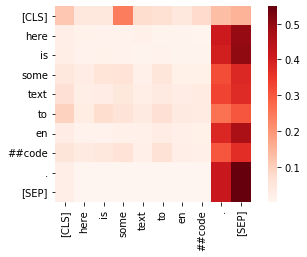

In [29]:
plt.figure() 
attention = attentions[layer-1][0][head-1].cpu().numpy()
df = pd.DataFrame(attention,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

### Attn-N visualization (Head-level visualization)

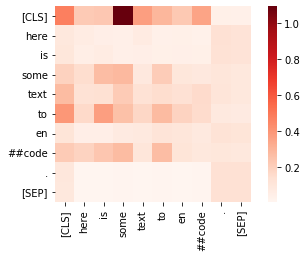

In [30]:
plt.figure() 
afx_norm = norms[layer-1][0]
norm = afx_norm[0][head-1].cpu().numpy()
df = pd.DataFrame(norm,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

### Attention weight (Attn-W) visualization (Layer-level visualization)

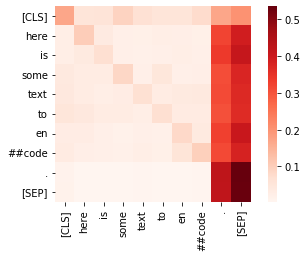

In [31]:
plt.figure() 
attention = attentions[layer-1][0].mean(0).cpu().numpy()
df = pd.DataFrame(attention,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

### Attn-N visualization (Layer-level visualization)

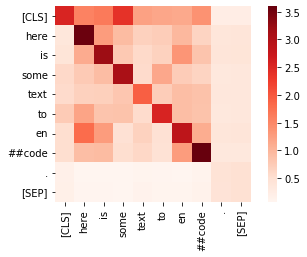

In [32]:
plt.figure() 
summed_afx_norm = norms[layer-1][1]
norm = summed_afx_norm[0].cpu().numpy()
df = pd.DataFrame(norm,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

### AttnRes-W visualization (Layer-level visualization)

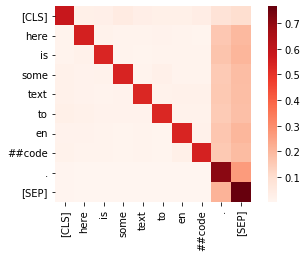

In [33]:
plt.figure() 
attention = attentions[layer-1][0].mean(0).cpu().numpy()
res = np.zeros((len(attention), len(attention)), int)
np.fill_diagonal(res, 1)
attnres_w = 0.5*attention + 0.5*res
df = pd.DataFrame(attnres_w,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

### AttnRes-N visualization (Layer-level visualization)

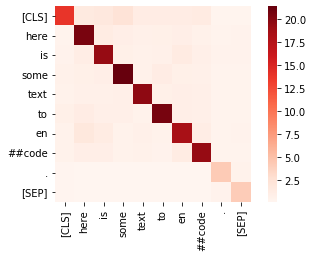

In [34]:
plt.figure() 
summed_afx_norm = norms[layer-1][2]
norm = summed_afx_norm[0].cpu().numpy()
df = pd.DataFrame(norm,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

### AttnResLn-N visualization (Layer-level visualization)

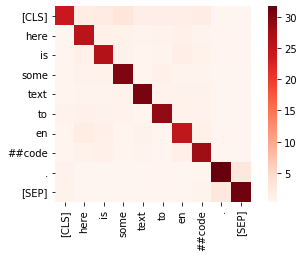

In [35]:
plt.figure() 
summed_afx_norm = norms[layer-1][3]
norm = summed_afx_norm[0].cpu().numpy()
df = pd.DataFrame(norm,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)